# CNN + MaxPool
First CNN with GenCode 43 data.

In [12]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-03-04 19:43:45.356135
Python 3.8.10
sklearn 1.2.1


In [13]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=3      
EMBED_DIMEN = 4 # arbitrary hyperparameter
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO' # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
CACHING = False   # have not worked out how to cache multiple cell lines
NUM_LINES = 15   # 15 to analyze all of them

In [14]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [15]:
RCI_FILE       = 'train.lncRNA_RCI.csv'
SEQUENCE_FILE  = 'train.canon_lncRNA_transcripts.csv'
CACHE_SEQUENCE = 'cache.seq.pickle'
CACHE_IDS      = 'cache.id.pickle'
if CACHING:
    cache_seq = DATA_DIR+CACHE_SEQUENCE 
    cache_ids = DATA_DIR+CACHE_IDS 
    if isfile(cache_seq) and isfile(cache_ids):
        print('WARNING: this run will read sequence from cache.')
    else:
        print('INFO: this run will write sequence to cache.')

In [16]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = []   # possibly exclude cell line 1 = H1.hESC

## Data Load

In [17]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_str = fields[cell_line]
                    if rci_str != "nan":
                        rci_val = float(rci_str)
                        gene_to_rci[gene_id] = rci_val
        print('Number of RCI values loaded',len(gene_to_rci.keys()))
        return gene_to_rci

    def seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        allids=[]
        allseq=[]
        cache_seq = DATA_DIR+CACHE_SEQUENCE 
        cache_ids = DATA_DIR+CACHE_IDS 
        if CACHING and isfile(cache_seq) and isfile(cache_ids):
            # Warning: the cache may represent the wrong K.
            with open(cache_seq,'rb') as fin:
                allseq = pickle.load(fin)
            with open(cache_ids,'rb') as fin:
                allids = pickle.load(fin)
            return allids,allseq           
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        if CACHING:
            with open(cache_seq,'wb') as fout:
                pickle.dump(allseq,fout)
            with open(cache_ids,'wb') as fout:
                pickle.dump(allids,fout)
        return allids,allseq

## Model

In [18]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [19]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-04 19:43:48.058922
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 4997, 4)           1028      
                                                                 
 conv1d_1 (Conv1D)           (None, 4982, 64)          4160      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 621, 64)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 39744)             0         
                                                                 
 dense_2 (Dense)             (None, 16)                635920    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                           

## Training

In [22]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False    
        
    def set_sequences(self, allids, allseq):
        # Keep IDs and sequences in same order.
        self.all_ids = allids  # pairs of (gene_id,tran_id)
        self.all_seqs = allseq  # may be vectors of K-mers
        genes = []
        for i in range(len(allids)):
            (one_gene,one_tran) = allids[i]
            genes.append(one_gene)
        self.all_genes = genes
            
    def set_rci_map(self, gene_to_rci):
        # The map is for fast lookup, not gene order.
        self.rci_map = gene_to_rci # map gene_id to RCI value
    
    def get_gene_subset(self, sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = self.all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes   # this is a set: unordered with fast lookup
    
    def _get_X_y(self, gene_index):
        cnt = len(self.all_ids)
        subsetX=[]
        subsetY=[]
        next_index = 0
        for i in range(cnt):
            if next_index==len(gene_index):
                break
            if i==gene_index[next_index]:
                gene_id,tran_id = self.all_ids[i]
                oneX = self.all_seqs[i]
                oneY = self.rci_map[gene_id]
                subsetX.append(oneX)
                subsetY.append(oneY)
                next_index += 1
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values):
        if self.mechanism == 'RCI_GMM':
            gmm = GaussianMixture(n_components=2, verbose=0, 
                covariance_type='spherical', n_init=100) 
            gmm.fit(rci_values)
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = 0
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
        
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        cv_auprc=[]
        cv_auroc=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        splits = splitter.split(self.all_genes)
        splitter = None
        for train_index,valid_index in splits:
            fold += 1
            print('Fold',fold)
            X_train,y_rci = self._get_X_y(train_index)
            self._prepare_threshold(y_rci)  # use train subset only!
            self._explain_threshold()
            y_train = self._apply_threshold(y_rci)
            X_valid,y_rci = self._get_X_y(valid_index)
            y_valid = self._apply_threshold(y_rci) 
            y_rci = None

            model=build_model()
            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
              epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none
              validation_data=(X_valid,y_valid) )
            print("PREDICT")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0)             
            yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)
            a = np.count_nonzero(y_valid==1)
            b = np.count_nonzero(y_valid==0)
            print('True 1:0 %d:%d %5.2f%%'%(a,b,100*a/(a+b)))
            a = np.count_nonzero(yhat_classes==1)
            b = np.count_nonzero(yhat_classes==0)
            print('Pred 1:0 %d:%d %5.2f%%'%(a,b,100*a/(a+b)))

            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            # PRC
            prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
            auprc = auc(prc_X,prc_Y)*100.
            auroc = roc_auc_score(y_valid, yhat_pred)*100.

            if PRETTY_PICTURES:
                pd.DataFrame(history.history).plot(figsize=(8,5))
                plt.grid(True)
                plt.gca().set_ylim(0,1)
                plt.show()

                print('Train set ones/size',
                      np.count_nonzero(y_train),'/',len(y_train))
                print("Compute valiation accuracy")
                print('Valid sizes',X_valid.shape,y_valid.shape)
                print('Valid set ones/size',
                      np.count_nonzero(y_valid),'/',len(y_valid))
                print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
                print('Score threshold',self.score_threshold)
                print('Prediction set ones/size',
                      np.count_nonzero(yhat_classes),'/',len(yhat_classes))

                count_ones= len(y_valid[y_valid==1])
                count_zeros= len(y_valid[y_valid==0])
                guess = max(count_ones,count_zeros) / len(y_valid)
                plt.plot(prc_X, prc_Y, marker='.')
                plt.plot([0, 1], [guess,guess], linestyle='--')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.show()
                # ROC
                fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
                plt.plot(fpr, tpr, marker='.')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.show()

            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% AUPRC: %.2f%% AUROC: %.2f%%' % (f1,auprc,auroc)) 
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            cv_auprc.append(auprc)
            cv_auroc.append(auroc)
            
            print(datetime.now())
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break

            # There is a memory leak within the fit() command!
            # Each successive call to fit() consumes more memory.
            model = None
            history = None
            prc_Y = None
            prc_X = None
            prc_bins = None
            yhat_classes = None
            X_train = None
            y_train = None
            X_valid = None
            y_valid = None
            tf.keras.backend.clear_session()
            gc.collect()
            time.sleep(1)  # hope gc kicks in
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc

2023-03-04 19:45:00.645766
Start cell Line 0 A549
Number of RCI values loaded 1635
Num RCI: 1635
Load sequence...
Cross validation...
2023-03-04 19:45:04.076024
splitting
Fold 1
Discriminator ZERO 0
FIT
2023-03-04 19:45:04.588814
PREDICT
2023-03-04 19:45:08.177820
True 1:0 213:309 40.80%
Pred 1:0 211:311 40.42%


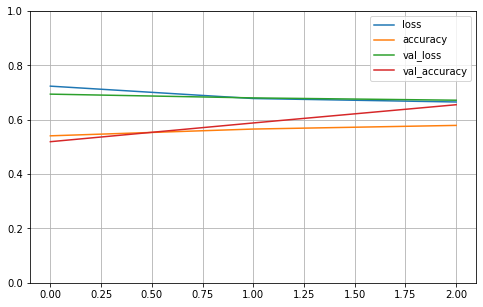

Train set ones/size 442 / 1043
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 213 / 522
Range of scores: 0.29105803 to 0.57852167
Score threshold 0.5
Prediction set ones/size 211 / 522


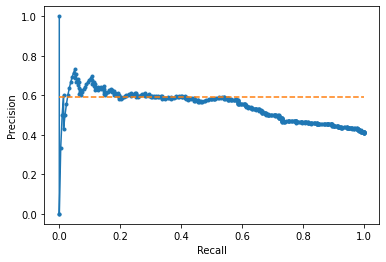

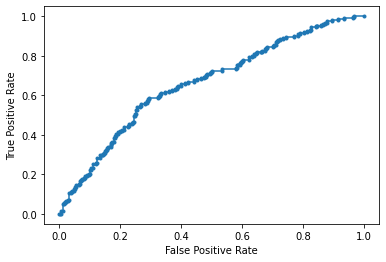

Accuracy: 65.52% Precision: 57.82% Recall: 57.28%
F1: 57.55% AUPRC: 54.70% AUROC: 66.05%
2023-03-04 19:45:09.056564
Fold 2
Discriminator ZERO 0
FIT
2023-03-04 19:45:10.824438
PREDICT
2023-03-04 19:45:14.283033
True 1:0 219:303 41.95%
Pred 1:0 46:476  8.81%


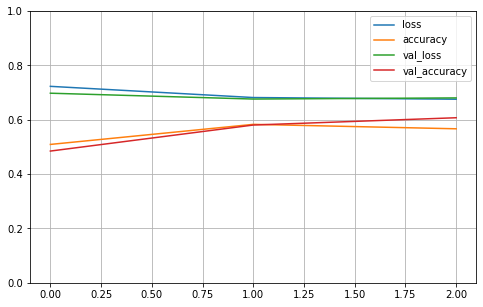

Train set ones/size 436 / 1043
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 219 / 522
Range of scores: 0.40614018 to 0.52639204
Score threshold 0.5
Prediction set ones/size 46 / 522


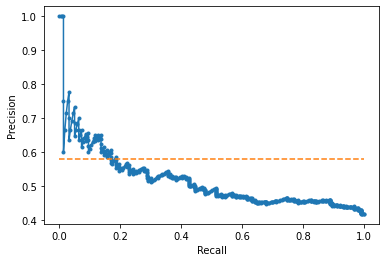

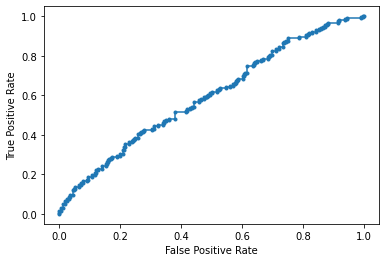

Accuracy: 60.73% Precision: 65.22% Recall: 13.70%
F1: 22.64% AUPRC: 51.82% AUROC: 59.59%
2023-03-04 19:45:15.553518
Fold 3
Discriminator ZERO 0
FIT
2023-03-04 19:45:17.335695
PREDICT
2023-03-04 19:45:20.912615
True 1:0 223:298 42.80%
Pred 1:0 28:493  5.37%


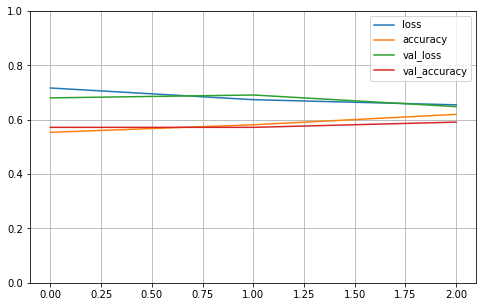

Train set ones/size 432 / 1044
Compute valiation accuracy
Valid sizes (521, 4997) (521,)
Valid set ones/size 223 / 521
Range of scores: 0.08727999 to 0.6419126
Score threshold 0.5
Prediction set ones/size 28 / 521


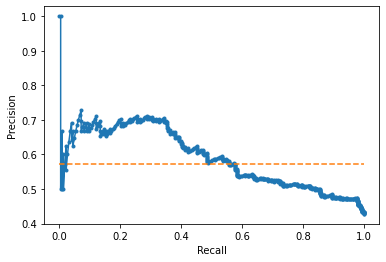

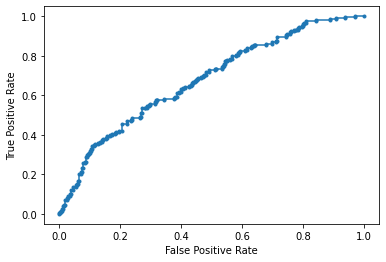

Accuracy: 59.12% Precision: 67.86% Recall: 8.52%
F1: 15.14% AUPRC: 59.13% AUROC: 67.76%
2023-03-04 19:45:21.749660

Completed cross validation 3 folds 3 epochs
Finished cell Line 0 A549

2023-03-04 19:45:23.027816
Start cell Line 1 H1.hESC
Number of RCI values loaded 3774
Num RCI: 3774
Load sequence...
Cross validation...
2023-03-04 19:45:30.168535
splitting
Fold 1
Discriminator ZERO 0
FIT
2023-03-04 19:45:31.249022
PREDICT
2023-03-04 19:45:36.042073
True 1:0 455:762 37.39%
Pred 1:0 131:1086 10.76%


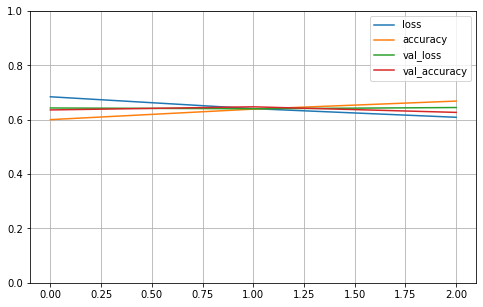

Train set ones/size 931 / 2432
Compute valiation accuracy
Valid sizes (1217, 4997) (1217,)
Valid set ones/size 455 / 1217
Range of scores: 0.010154894 to 0.86718166
Score threshold 0.5
Prediction set ones/size 131 / 1217


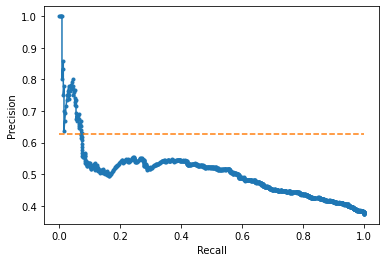

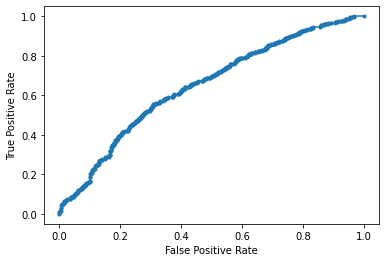

Accuracy: 62.70% Precision: 50.38% Recall: 14.51%
F1: 22.53% AUPRC: 50.74% AUROC: 64.88%
2023-03-04 19:45:37.037818
Fold 2
Discriminator ZERO 0
FIT
2023-03-04 19:45:39.369215
PREDICT
2023-03-04 19:45:46.088037
True 1:0 472:744 38.82%
Pred 1:0 24:1192  1.97%


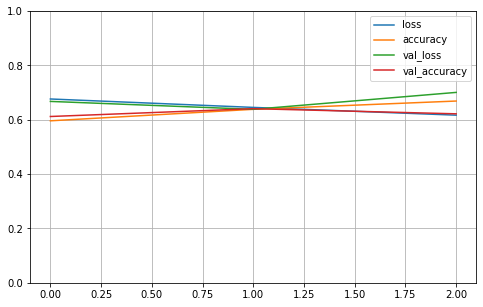

Train set ones/size 914 / 2433
Compute valiation accuracy
Valid sizes (1216, 4997) (1216,)
Valid set ones/size 472 / 1216
Range of scores: 0.0032907142 to 0.6845369
Score threshold 0.5
Prediction set ones/size 24 / 1216


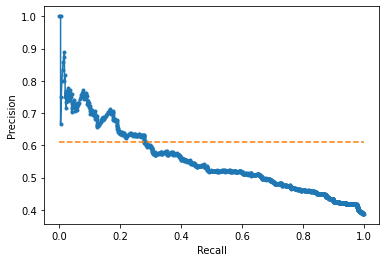

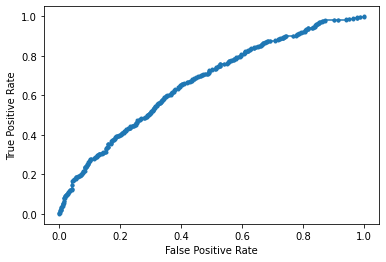

Accuracy: 62.17% Precision: 75.00% Recall: 3.81%
F1: 7.26% AUPRC: 55.53% AUROC: 66.74%
2023-03-04 19:45:47.196102
Fold 3
Discriminator ZERO 0
FIT
2023-03-04 19:45:49.509394
PREDICT
2023-03-04 19:45:54.845372
True 1:0 459:757 37.75%
Pred 1:0 194:1022 15.95%


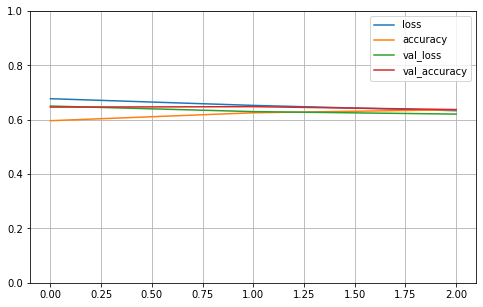

Train set ones/size 927 / 2433
Compute valiation accuracy
Valid sizes (1216, 4997) (1216,)
Valid set ones/size 459 / 1216
Range of scores: 0.060809158 to 0.9639093
Score threshold 0.5
Prediction set ones/size 194 / 1216


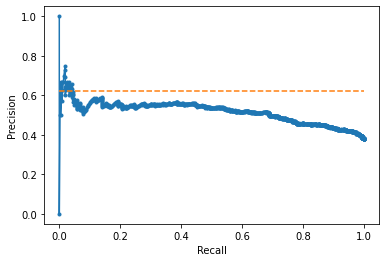

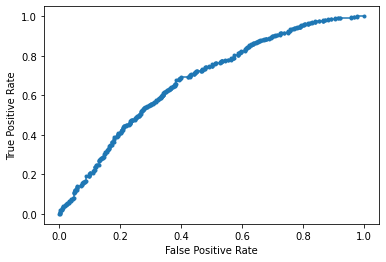

Accuracy: 63.73% Precision: 54.64% Recall: 23.09%
F1: 32.47% AUPRC: 51.75% AUROC: 67.71%
2023-03-04 19:45:56.349608

Completed cross validation 3 folds 3 epochs
Finished cell Line 1 H1.hESC

2023-03-04 19:45:57.680236
Start cell Line 2 HeLa.S3
Number of RCI values loaded 999
Num RCI: 999
Load sequence...
Cross validation...
2023-03-04 19:45:59.071233
splitting
Fold 1
Discriminator ZERO 0
FIT
2023-03-04 19:45:59.448043
PREDICT
2023-03-04 19:46:02.207942
True 1:0 60:258 18.87%
Pred 1:0 0:318  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


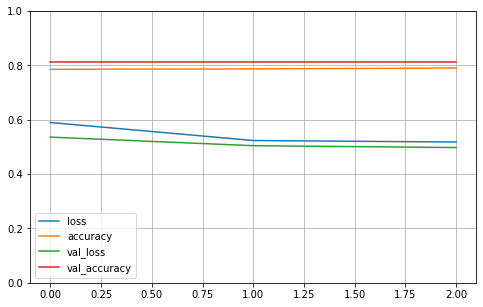

Train set ones/size 131 / 634
Compute valiation accuracy
Valid sizes (318, 4997) (318,)
Valid set ones/size 60 / 318
Range of scores: 0.1465542 to 0.3450627
Score threshold 0.5
Prediction set ones/size 0 / 318


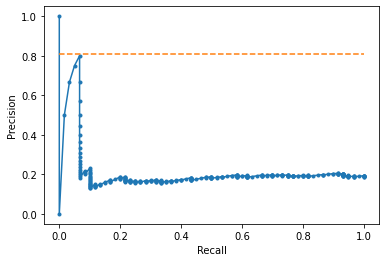

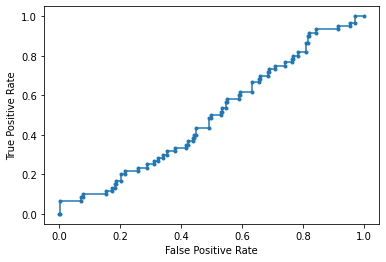

Accuracy: 81.13% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 20.93% AUROC: 49.81%
2023-03-04 19:46:03.017016
Fold 2
Discriminator ZERO 0
FIT
2023-03-04 19:46:04.611741
PREDICT
2023-03-04 19:46:07.518966
True 1:0 64:253 20.19%
Pred 1:0 0:317  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


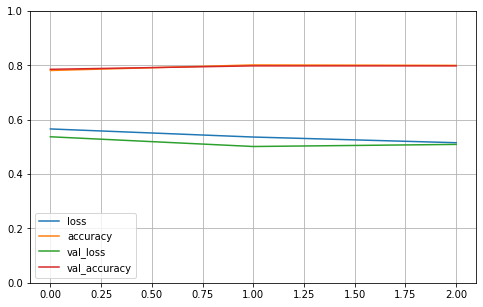

Train set ones/size 127 / 635
Compute valiation accuracy
Valid sizes (317, 4997) (317,)
Valid set ones/size 64 / 317
Range of scores: 0.09241186 to 0.3028974
Score threshold 0.5
Prediction set ones/size 0 / 317


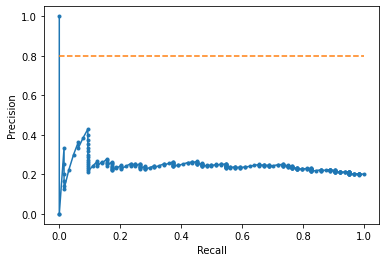

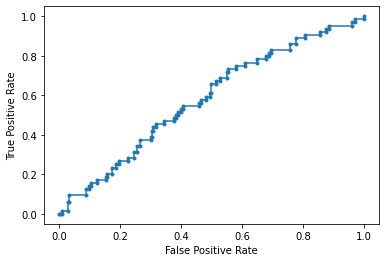

Accuracy: 79.81% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 24.23% AUROC: 58.26%
2023-03-04 19:46:08.851028
Fold 3
Discriminator ZERO 0
FIT
2023-03-04 19:46:10.527924
PREDICT
2023-03-04 19:46:13.136116
True 1:0 67:250 21.14%
Pred 1:0 5:312  1.58%


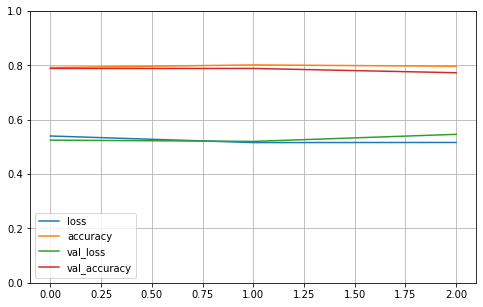

Train set ones/size 124 / 635
Compute valiation accuracy
Valid sizes (317, 4997) (317,)
Valid set ones/size 67 / 317
Range of scores: 0.10610604 to 0.55827427
Score threshold 0.5
Prediction set ones/size 5 / 317


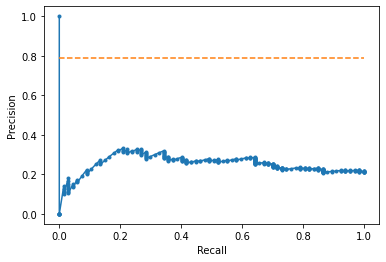

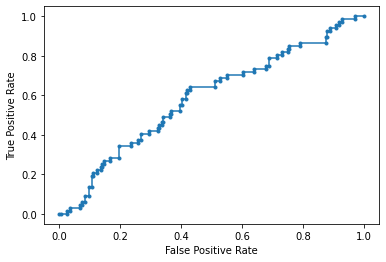

Accuracy: 77.29% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 25.11% AUROC: 58.69%
2023-03-04 19:46:13.963562

Completed cross validation 3 folds 3 epochs
Finished cell Line 2 HeLa.S3

2023-03-04 19:46:15.238494
Start cell Line 3 HepG2
Number of RCI values loaded 1560
Num RCI: 1560
Load sequence...
Cross validation...
2023-03-04 19:46:17.389814
splitting
Fold 1
Discriminator ZERO 0
FIT
2023-03-04 19:46:17.867862
PREDICT
2023-03-04 19:46:21.259095
True 1:0 133:362 26.87%
Pred 1:0 0:495  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


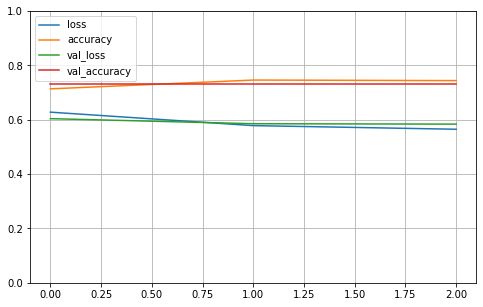

Train set ones/size 253 / 988
Compute valiation accuracy
Valid sizes (495, 4997) (495,)
Valid set ones/size 133 / 495
Range of scores: 0.1297588 to 0.44899568
Score threshold 0.5
Prediction set ones/size 0 / 495


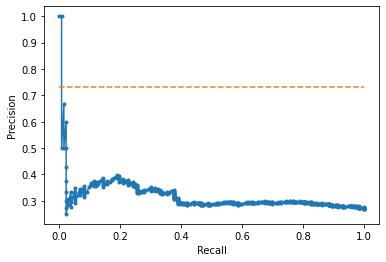

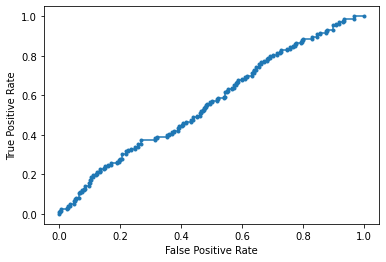

Accuracy: 73.13% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 31.98% AUROC: 56.25%
2023-03-04 19:46:22.555408
Fold 2
Discriminator ZERO 0
FIT
2023-03-04 19:46:24.363744
PREDICT
2023-03-04 19:46:27.914952
True 1:0 131:363 26.52%
Pred 1:0 0:494  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


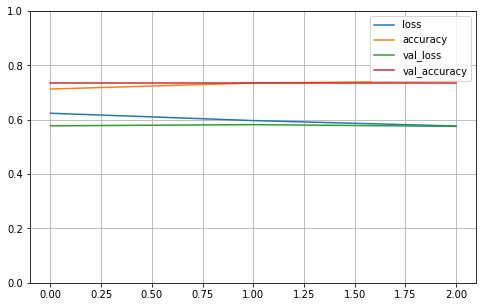

Train set ones/size 255 / 989
Compute valiation accuracy
Valid sizes (494, 4997) (494,)
Valid set ones/size 131 / 494
Range of scores: 0.09239952 to 0.3590575
Score threshold 0.5
Prediction set ones/size 0 / 494


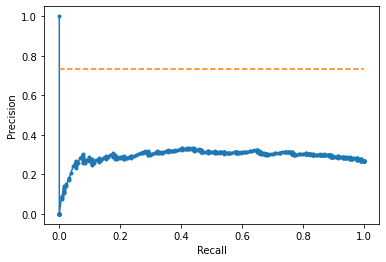

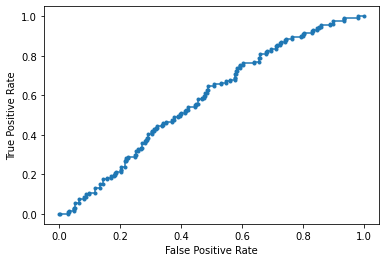

Accuracy: 73.48% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 29.37% AUROC: 58.12%
2023-03-04 19:46:28.811173
Fold 3
Discriminator ZERO 0
FIT
2023-03-04 19:46:30.566943
PREDICT
2023-03-04 19:46:34.122079
True 1:0 122:372 24.70%
Pred 1:0 0:494  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


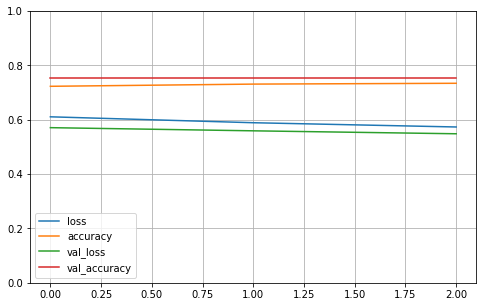

Train set ones/size 264 / 989
Compute valiation accuracy
Valid sizes (494, 4997) (494,)
Valid set ones/size 122 / 494
Range of scores: 0.068866245 to 0.35619393
Score threshold 0.5
Prediction set ones/size 0 / 494


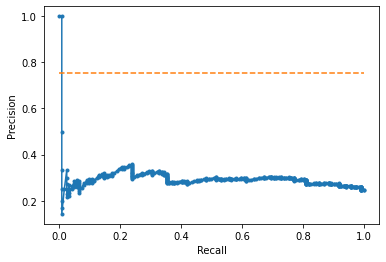

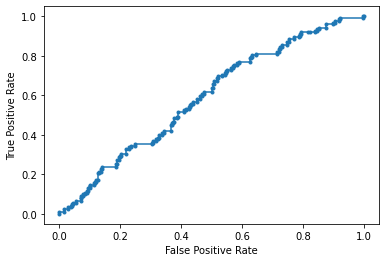

Accuracy: 75.30% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 29.72% AUROC: 59.12%
2023-03-04 19:46:35.394796

Completed cross validation 3 folds 3 epochs
Finished cell Line 3 HepG2

2023-03-04 19:46:36.755318
Start cell Line 4 HT1080
Number of RCI values loaded 1050
Num RCI: 1050
Load sequence...
Cross validation...
2023-03-04 19:46:38.173911
splitting
Fold 1
Discriminator ZERO 0
FIT
2023-03-04 19:46:38.528191
PREDICT
2023-03-04 19:46:42.110616
True 1:0 140:189 42.55%
Pred 1:0 18:311  5.47%


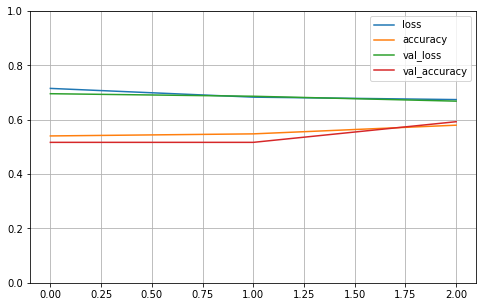

Train set ones/size 298 / 657
Compute valiation accuracy
Valid sizes (329, 4997) (329,)
Valid set ones/size 140 / 329
Range of scores: 0.2999013 to 0.52190113
Score threshold 0.5
Prediction set ones/size 18 / 329


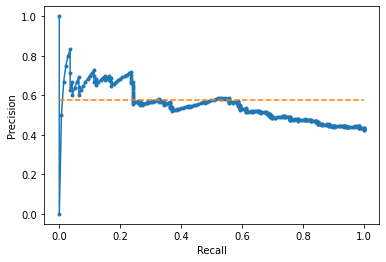

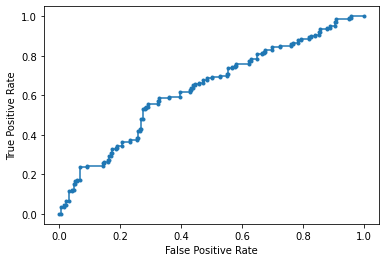

Accuracy: 59.27% Precision: 66.67% Recall: 8.57%
F1: 15.19% AUPRC: 55.24% AUROC: 63.48%
2023-03-04 19:46:42.941498
Fold 2
Discriminator ZERO 0
FIT
2023-03-04 19:46:44.573273
PREDICT
2023-03-04 19:46:48.167534
True 1:0 144:185 43.77%
Pred 1:0 7:322  2.13%


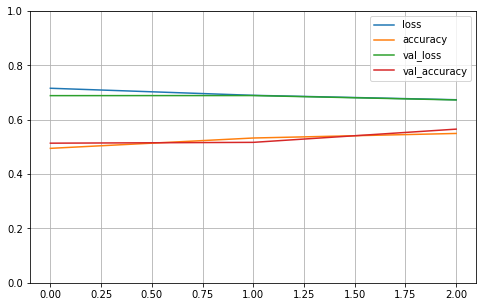

Train set ones/size 294 / 657
Compute valiation accuracy
Valid sizes (329, 4997) (329,)
Valid set ones/size 144 / 329
Range of scores: 0.23429029 to 0.51985615
Score threshold 0.5
Prediction set ones/size 7 / 329


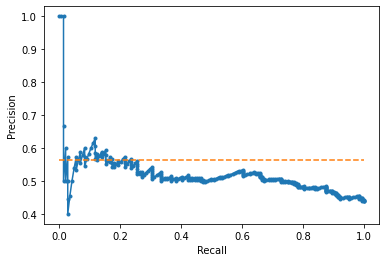

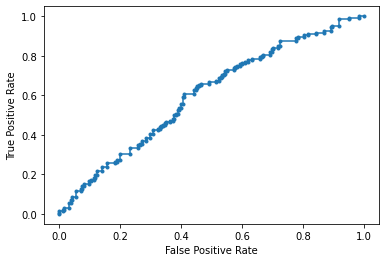

Accuracy: 56.53% Precision: 57.14% Recall: 2.78%
F1: 5.30% AUPRC: 51.95% AUROC: 60.16%
2023-03-04 19:46:49.448948
Fold 3
Discriminator ZERO 0
FIT
2023-03-04 19:46:51.072252
PREDICT
2023-03-04 19:46:53.822368
True 1:0 154:174 46.95%
Pred 1:0 0:328  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


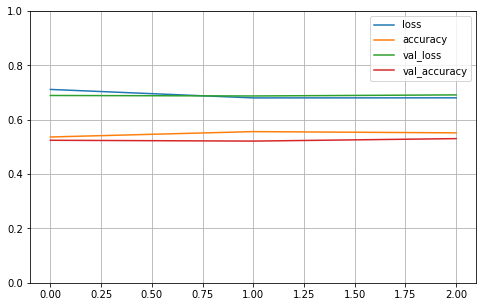

Train set ones/size 284 / 658
Compute valiation accuracy
Valid sizes (328, 4997) (328,)
Valid set ones/size 154 / 328
Range of scores: 0.26386425 to 0.48215428
Score threshold 0.5
Prediction set ones/size 0 / 328


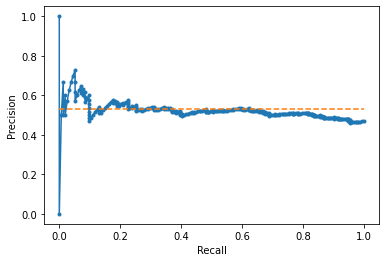

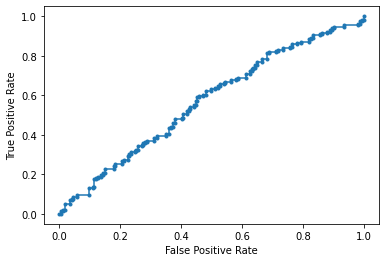

Accuracy: 53.05% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 52.21% AUROC: 56.91%
2023-03-04 19:46:54.713243

Completed cross validation 3 folds 3 epochs
Finished cell Line 4 HT1080

2023-03-04 19:46:55.985410
Start cell Line 5 HUVEC
Number of RCI values loaded 1674
Num RCI: 1674
Load sequence...
Cross validation...
2023-03-04 19:46:58.256708
splitting
Fold 1
Discriminator ZERO 0
FIT
2023-03-04 19:46:58.766889
PREDICT
2023-03-04 19:47:02.891615
True 1:0 150:383 28.14%
Pred 1:0 0:533  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


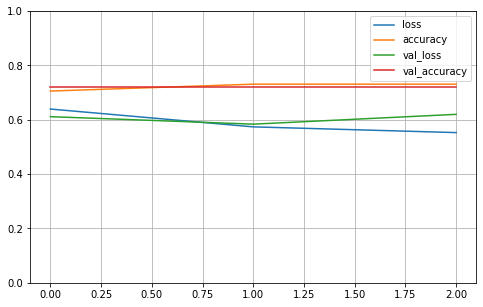

Train set ones/size 286 / 1066
Compute valiation accuracy
Valid sizes (533, 4997) (533,)
Valid set ones/size 150 / 533
Range of scores: 0.013830168 to 0.46518826
Score threshold 0.5
Prediction set ones/size 0 / 533


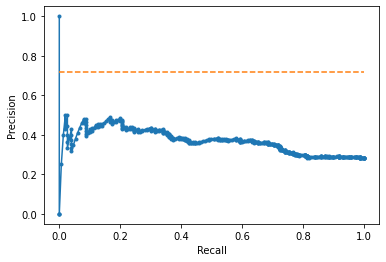

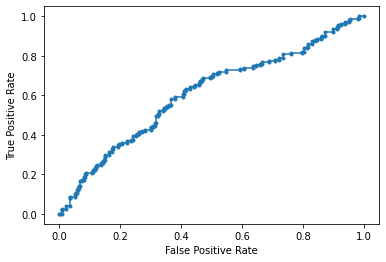

Accuracy: 71.86% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 36.88% AUROC: 60.93%
2023-03-04 19:47:03.783495
Fold 2
Discriminator ZERO 0
FIT
2023-03-04 19:47:05.574513
PREDICT
2023-03-04 19:47:08.859324
True 1:0 154:379 28.89%
Pred 1:0 7:526  1.31%


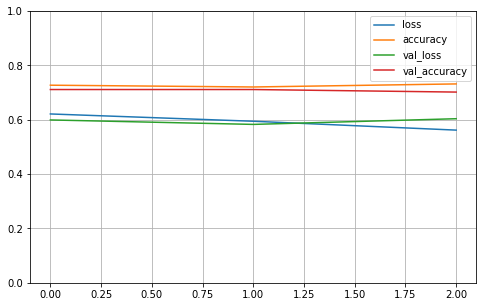

Train set ones/size 282 / 1066
Compute valiation accuracy
Valid sizes (533, 4997) (533,)
Valid set ones/size 154 / 533
Range of scores: 0.0148141505 to 0.64356226
Score threshold 0.5
Prediction set ones/size 7 / 533


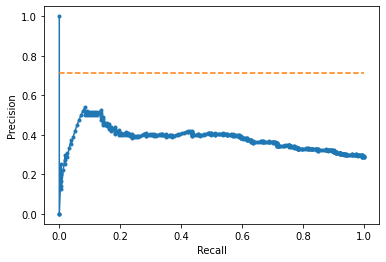

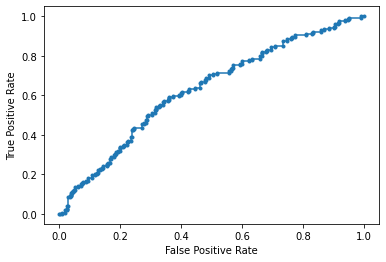

Accuracy: 70.17% Precision: 14.29% Recall: 0.65%
F1: 1.24% AUPRC: 37.92% AUROC: 62.81%
2023-03-04 19:47:09.693783
Fold 3
Discriminator ZERO 0
FIT
2023-03-04 19:47:11.486930
PREDICT
2023-03-04 19:47:15.222097
True 1:0 132:401 24.77%
Pred 1:0 22:511  4.13%


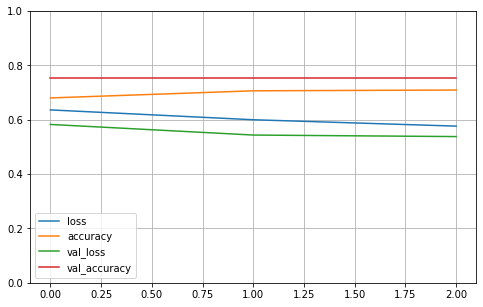

Train set ones/size 304 / 1066
Compute valiation accuracy
Valid sizes (533, 4997) (533,)
Valid set ones/size 132 / 533
Range of scores: 0.12295022 to 0.58847654
Score threshold 0.5
Prediction set ones/size 22 / 533


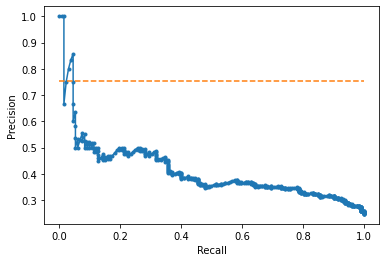

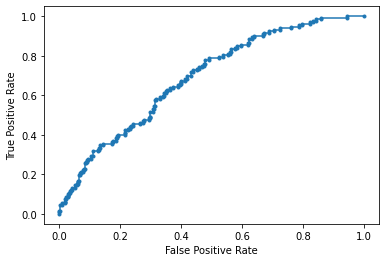

Accuracy: 75.23% Precision: 50.00% Recall: 8.33%
F1: 14.29% AUPRC: 41.31% AUROC: 69.04%
2023-03-04 19:47:16.410542

Completed cross validation 3 folds 3 epochs
Finished cell Line 5 HUVEC

2023-03-04 19:47:17.707227
Start cell Line 6 MCF.7
Number of RCI values loaded 2377
Num RCI: 2377
Load sequence...
Cross validation...
2023-03-04 19:47:20.888682
splitting
Fold 1
Discriminator ZERO 0
FIT
2023-03-04 19:47:21.588038
PREDICT
2023-03-04 19:47:25.335891
True 1:0 197:569 25.72%
Pred 1:0 17:749  2.22%


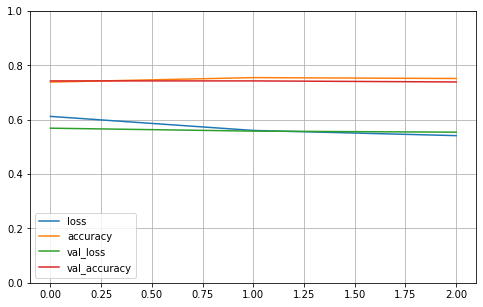

Train set ones/size 375 / 1530
Compute valiation accuracy
Valid sizes (766, 4997) (766,)
Valid set ones/size 197 / 766
Range of scores: 0.035831936 to 0.5717785
Score threshold 0.5
Prediction set ones/size 17 / 766


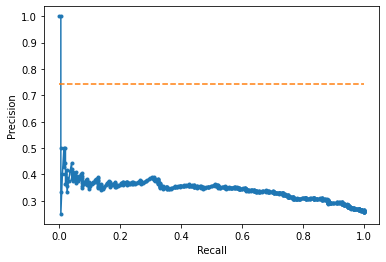

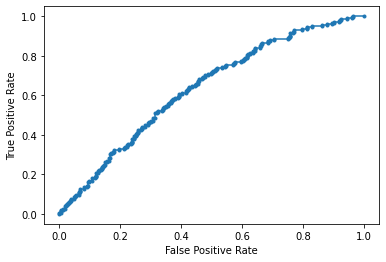

Accuracy: 73.89% Precision: 41.18% Recall: 3.55%
F1: 6.54% AUPRC: 34.56% AUROC: 63.56%
2023-03-04 19:47:26.261405
Fold 2
Discriminator ZERO 0
FIT
2023-03-04 19:47:28.863980
PREDICT
2023-03-04 19:47:32.573347
True 1:0 198:567 25.88%
Pred 1:0 37:728  4.84%


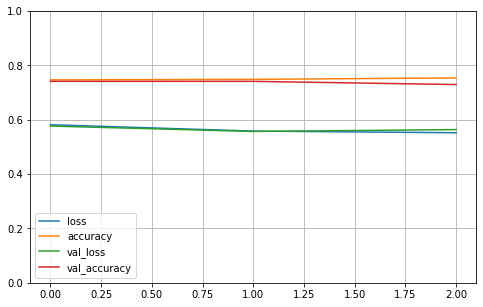

Train set ones/size 374 / 1531
Compute valiation accuracy
Valid sizes (765, 4997) (765,)
Valid set ones/size 198 / 765
Range of scores: 0.083806336 to 0.62101203
Score threshold 0.5
Prediction set ones/size 37 / 765


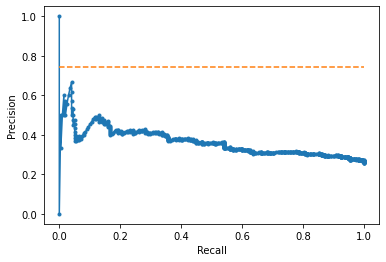

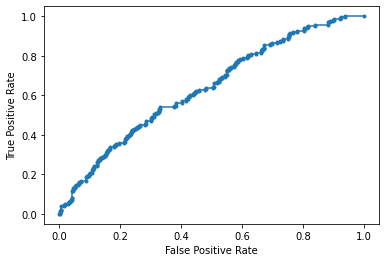

Accuracy: 72.94% Precision: 37.84% Recall: 7.07%
F1: 11.91% AUPRC: 36.36% AUROC: 63.48%
2023-03-04 19:47:33.510024
Fold 3
Discriminator ZERO 0
FIT
2023-03-04 19:47:35.525117
PREDICT
2023-03-04 19:47:41.699898
True 1:0 177:588 23.14%
Pred 1:0 2:763  0.26%


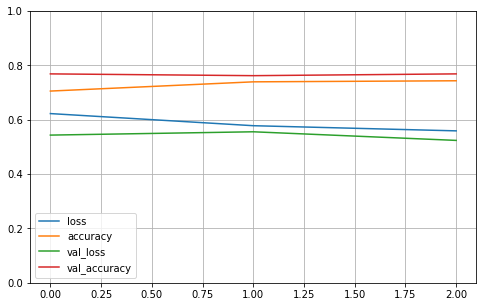

Train set ones/size 395 / 1531
Compute valiation accuracy
Valid sizes (765, 4997) (765,)
Valid set ones/size 177 / 765
Range of scores: 0.073893875 to 0.5120683
Score threshold 0.5
Prediction set ones/size 2 / 765


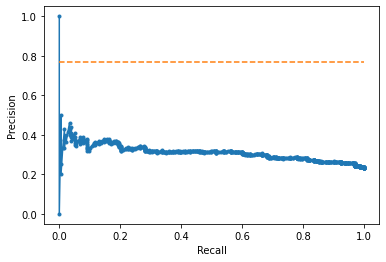

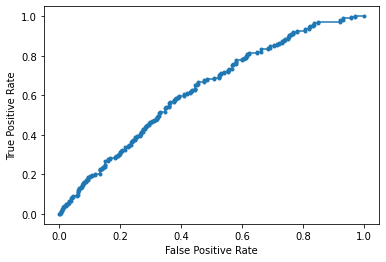

Accuracy: 76.86% Precision: 50.00% Recall: 0.56%
F1: 1.12% AUPRC: 31.03% AUROC: 62.87%
2023-03-04 19:47:43.411618

Completed cross validation 3 folds 3 epochs
Finished cell Line 6 MCF.7

2023-03-04 19:47:44.843996
Start cell Line 7 NCI.H460
Number of RCI values loaded 700
Num RCI: 700
Load sequence...
Cross validation...
2023-03-04 19:47:45.892640
splitting
Fold 1
Discriminator ZERO 0
FIT
2023-03-04 19:47:46.184615
PREDICT
2023-03-04 19:47:48.668794
True 1:0 43:174 19.82%
Pred 1:0 0:217  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


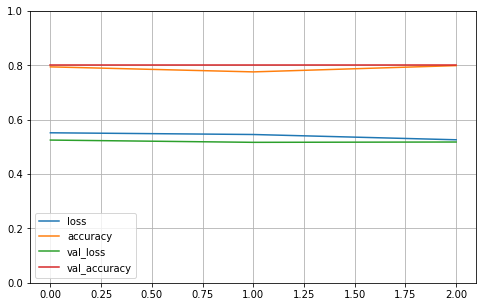

Train set ones/size 80 / 433
Compute valiation accuracy
Valid sizes (217, 4997) (217,)
Valid set ones/size 43 / 217
Range of scores: 0.105998464 to 0.3775128
Score threshold 0.5
Prediction set ones/size 0 / 217


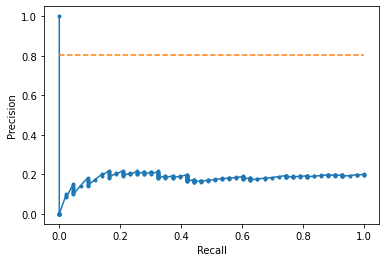

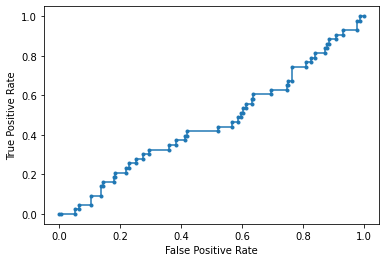

Accuracy: 80.18% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 18.15% AUROC: 46.27%
2023-03-04 19:47:49.479516
Fold 2
Discriminator ZERO 0
FIT
2023-03-04 19:47:51.023704
PREDICT
2023-03-04 19:47:54.546848
True 1:0 48:169 22.12%
Pred 1:0 0:217  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


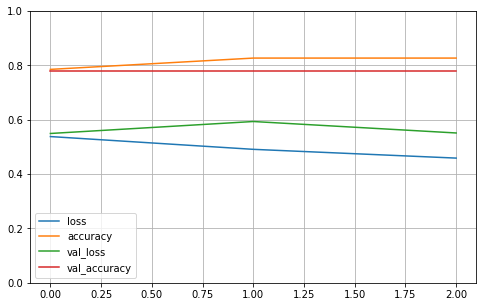

Train set ones/size 75 / 433
Compute valiation accuracy
Valid sizes (217, 4997) (217,)
Valid set ones/size 48 / 217
Range of scores: 0.16377687 to 0.40522647
Score threshold 0.5
Prediction set ones/size 0 / 217


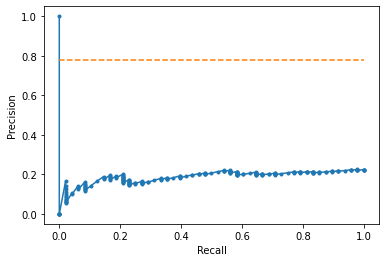

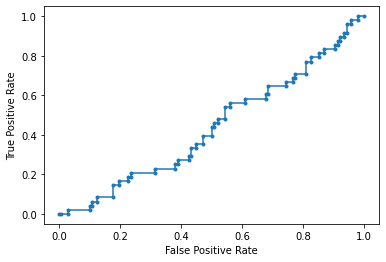

Accuracy: 77.88% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 18.78% AUROC: 43.75%
2023-03-04 19:47:55.757374
Fold 3
Discriminator ZERO 0
FIT
2023-03-04 19:47:57.387167
PREDICT
2023-03-04 19:47:59.891439
True 1:0 32:184 14.81%
Pred 1:0 0:216  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


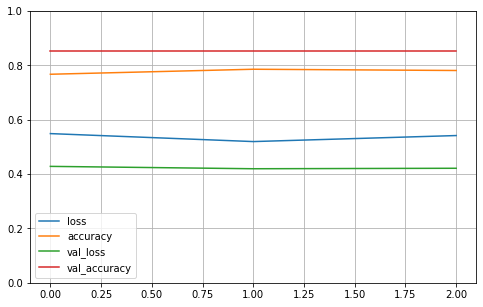

Train set ones/size 91 / 434
Compute valiation accuracy
Valid sizes (216, 4997) (216,)
Valid set ones/size 32 / 216
Range of scores: 0.11819442 to 0.29277655
Score threshold 0.5
Prediction set ones/size 0 / 216


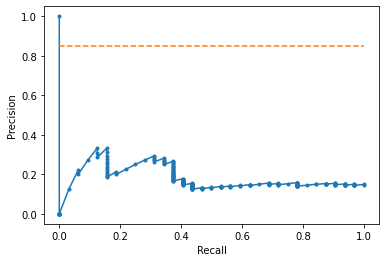

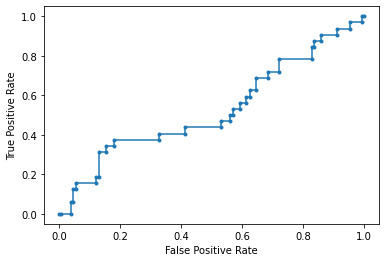

Accuracy: 85.19% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 17.97% AUROC: 52.90%
2023-03-04 19:48:00.689907

Completed cross validation 3 folds 3 epochs
Finished cell Line 7 NCI.H460

2023-03-04 19:48:01.963257
Start cell Line 8 NHEK
Number of RCI values loaded 1214
Num RCI: 1214
Load sequence...
Cross validation...
2023-03-04 19:48:03.679994
splitting
Fold 1
Discriminator ZERO 0
FIT
2023-03-04 19:48:04.080385
PREDICT
2023-03-04 19:48:07.959351
True 1:0 132:253 34.29%
Pred 1:0 0:385  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


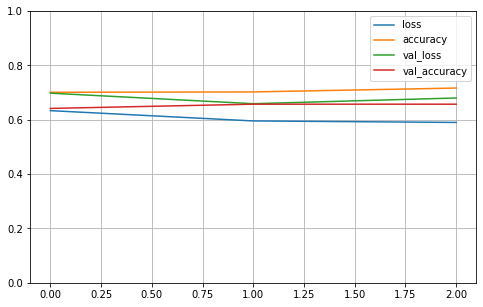

Train set ones/size 213 / 769
Compute valiation accuracy
Valid sizes (385, 4997) (385,)
Valid set ones/size 132 / 385
Range of scores: 0.12647851 to 0.39545673
Score threshold 0.5
Prediction set ones/size 0 / 385


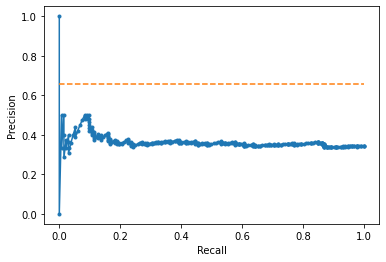

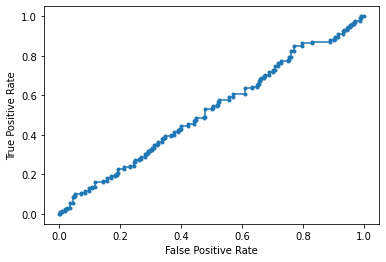

Accuracy: 65.71% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 36.20% AUROC: 52.19%
2023-03-04 19:48:09.263721
Fold 2
Discriminator ZERO 0
FIT
2023-03-04 19:48:11.052452
PREDICT
2023-03-04 19:48:14.655298
True 1:0 96:289 24.94%
Pred 1:0 0:385  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


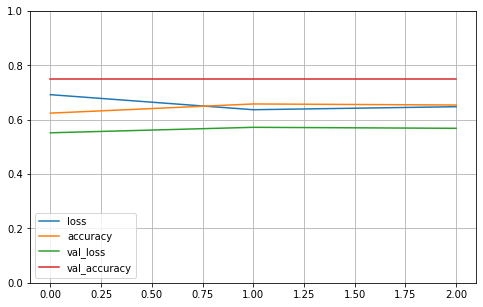

Train set ones/size 249 / 769
Compute valiation accuracy
Valid sizes (385, 4997) (385,)
Valid set ones/size 96 / 385
Range of scores: 0.24125078 to 0.44246784
Score threshold 0.5
Prediction set ones/size 0 / 385


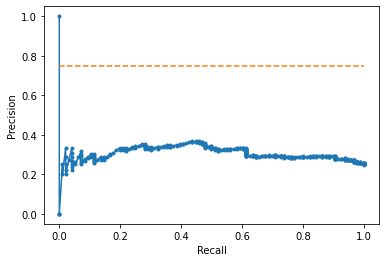

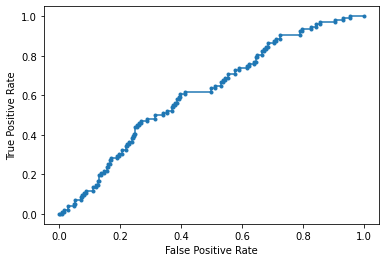

Accuracy: 75.06% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 30.61% AUROC: 61.43%
2023-03-04 19:48:15.557526
Fold 3
Discriminator ZERO 0
FIT
2023-03-04 19:48:17.699265
PREDICT
2023-03-04 19:48:21.291294
True 1:0 117:267 30.47%
Pred 1:0 0:384  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


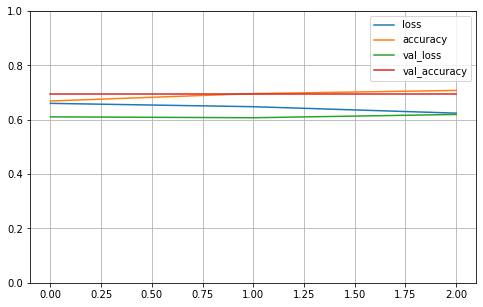

Train set ones/size 228 / 770
Compute valiation accuracy
Valid sizes (384, 4997) (384,)
Valid set ones/size 117 / 384
Range of scores: 0.27381337 to 0.47118953
Score threshold 0.5
Prediction set ones/size 0 / 384


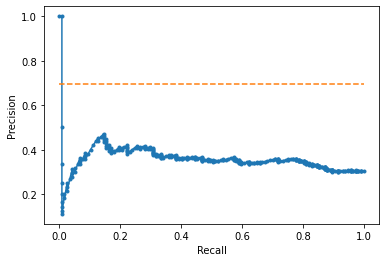

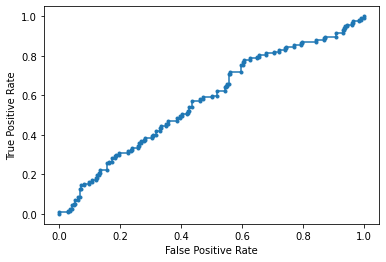

Accuracy: 69.53% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 35.98% AUROC: 57.75%
2023-03-04 19:48:22.541743

Completed cross validation 3 folds 3 epochs
Finished cell Line 8 NHEK

2023-03-04 19:48:23.945074
Start cell Line 9 SK.MEL.5
Number of RCI values loaded 618
Num RCI: 618
Load sequence...
Cross validation...
2023-03-04 19:48:24.820256
splitting
Fold 1
Discriminator ZERO 0
FIT
2023-03-04 19:48:25.099049
PREDICT
2023-03-04 19:48:28.709697
True 1:0 41:150 21.47%
Pred 1:0 0:191  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


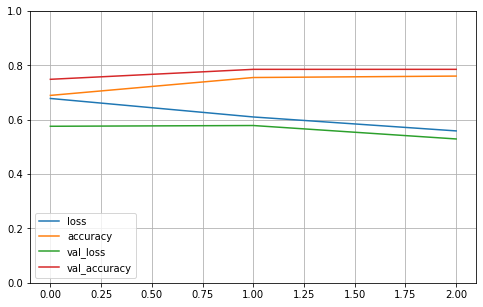

Train set ones/size 89 / 380
Compute valiation accuracy
Valid sizes (191, 4997) (191,)
Valid set ones/size 41 / 191
Range of scores: 0.1703928 to 0.39056942
Score threshold 0.5
Prediction set ones/size 0 / 191


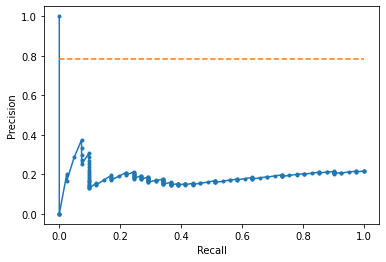

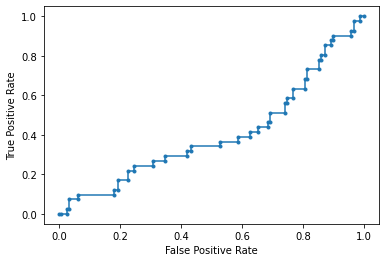

Accuracy: 78.53% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 18.71% AUROC: 40.54%
2023-03-04 19:48:29.553193
Fold 2
Discriminator ZERO 0
FIT
2023-03-04 19:48:31.068909
PREDICT
2023-03-04 19:48:33.425385
True 1:0 39:151 20.53%
Pred 1:0 0:190  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


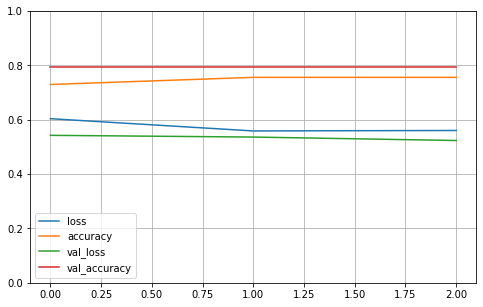

Train set ones/size 91 / 381
Compute valiation accuracy
Valid sizes (190, 4997) (190,)
Valid set ones/size 39 / 190
Range of scores: 0.13389413 to 0.27738872
Score threshold 0.5
Prediction set ones/size 0 / 190


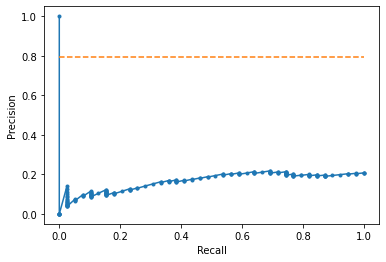

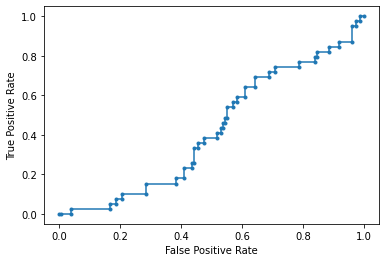

Accuracy: 79.47% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 16.58% AUROC: 42.37%
2023-03-04 19:48:34.656442
Fold 3
Discriminator ZERO 0
FIT
2023-03-04 19:48:36.358834
PREDICT
2023-03-04 19:48:39.900806
True 1:0 50:140 26.32%
Pred 1:0 0:190  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


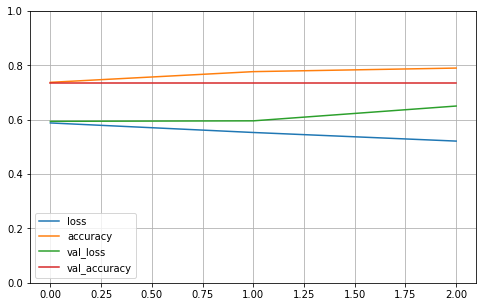

Train set ones/size 80 / 381
Compute valiation accuracy
Valid sizes (190, 4997) (190,)
Valid set ones/size 50 / 190
Range of scores: 0.08579064 to 0.23126309
Score threshold 0.5
Prediction set ones/size 0 / 190


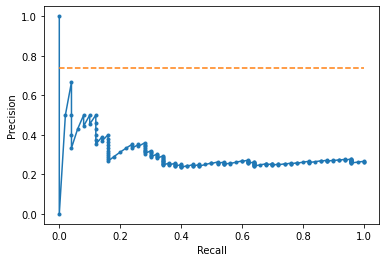

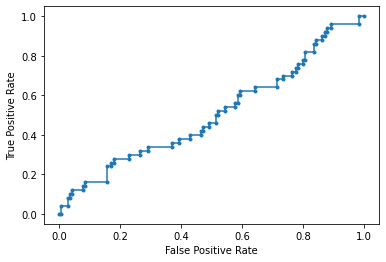

Accuracy: 73.68% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 29.42% AUROC: 50.64%
2023-03-04 19:48:40.717234

Completed cross validation 3 folds 3 epochs
Finished cell Line 9 SK.MEL.5

2023-03-04 19:48:41.986659
Start cell Line 10 SK.N.DZ
Number of RCI values loaded 683
Num RCI: 683
Load sequence...
Cross validation...
2023-03-04 19:48:42.979505
splitting
Fold 1
Discriminator ZERO 0
FIT
2023-03-04 19:48:43.239247
PREDICT
2023-03-04 19:48:46.771041
True 1:0 83:128 39.34%
Pred 1:0 43:168 20.38%


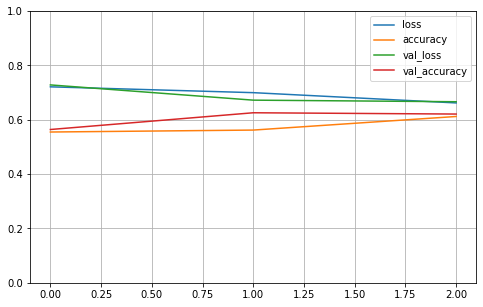

Train set ones/size 167 / 420
Compute valiation accuracy
Valid sizes (211, 4997) (211,)
Valid set ones/size 83 / 211
Range of scores: 0.3258598 to 0.5538218
Score threshold 0.5
Prediction set ones/size 43 / 211


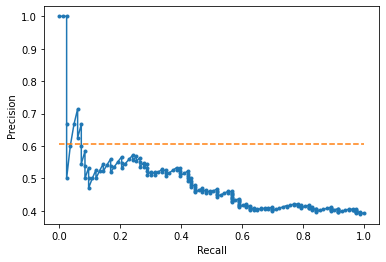

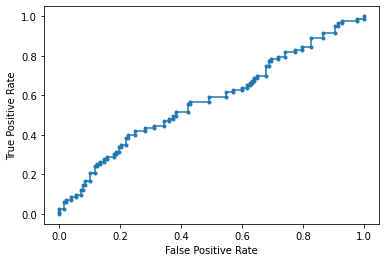

Accuracy: 62.09% Precision: 53.49% Recall: 27.71%
F1: 36.51% AUPRC: 48.44% AUROC: 57.55%
2023-03-04 19:48:48.084398
Fold 2
Discriminator ZERO 0
FIT
2023-03-04 19:48:49.744785
PREDICT
2023-03-04 19:48:52.097974
True 1:0 87:123 41.43%
Pred 1:0 0:210  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


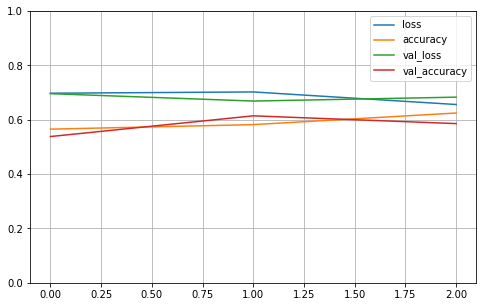

Train set ones/size 163 / 421
Compute valiation accuracy
Valid sizes (210, 4997) (210,)
Valid set ones/size 87 / 210
Range of scores: 0.2305448 to 0.442785
Score threshold 0.5
Prediction set ones/size 0 / 210


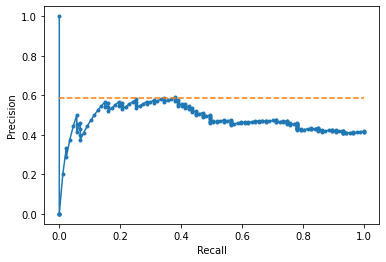

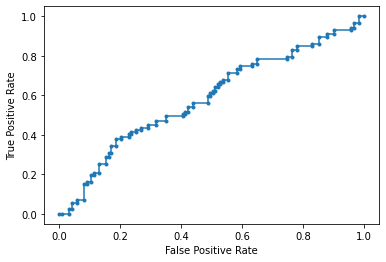

Accuracy: 58.57% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 47.68% AUROC: 58.59%
2023-03-04 19:48:52.940292
Fold 3
Discriminator ZERO 0
FIT
2023-03-04 19:48:54.472444
PREDICT
2023-03-04 19:48:56.884029
True 1:0 80:130 38.10%
Pred 1:0 21:189 10.00%


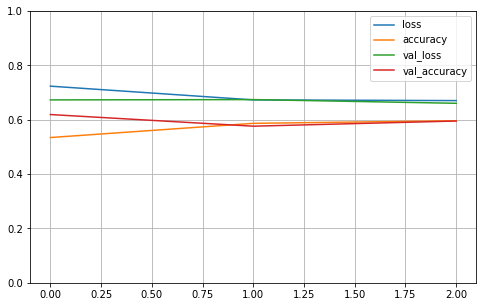

Train set ones/size 170 / 421
Compute valiation accuracy
Valid sizes (210, 4997) (210,)
Valid set ones/size 80 / 210
Range of scores: 0.28122908 to 0.53957343
Score threshold 0.5
Prediction set ones/size 21 / 210


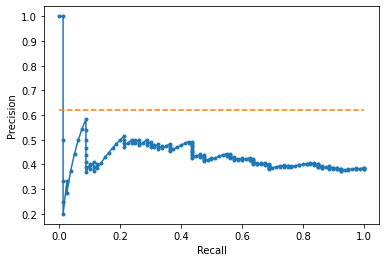

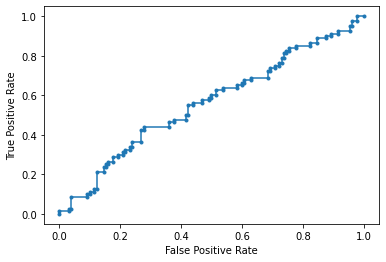

Accuracy: 59.52% Precision: 38.10% Recall: 10.00%
F1: 15.84% AUPRC: 43.45% AUROC: 56.01%
2023-03-04 19:48:57.692848

Completed cross validation 3 folds 3 epochs
Finished cell Line 10 SK.N.DZ

2023-03-04 19:48:58.966414
Start cell Line 11 SK.N.SH
Number of RCI values loaded 1865
Num RCI: 1865
Load sequence...
Cross validation...
2023-03-04 19:49:03.601973
splitting
Fold 1
Discriminator ZERO 0
FIT
2023-03-04 19:49:04.170772
PREDICT
2023-03-04 19:49:07.790667
True 1:0 162:434 27.18%
Pred 1:0 0:596  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


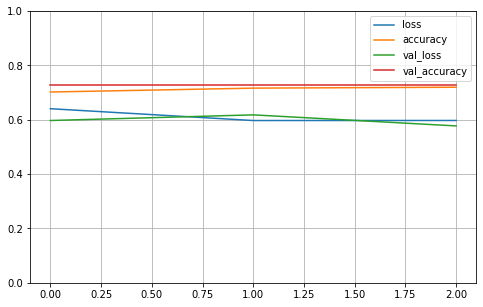

Train set ones/size 332 / 1191
Compute valiation accuracy
Valid sizes (596, 4997) (596,)
Valid set ones/size 162 / 596
Range of scores: 0.13823755 to 0.437783
Score threshold 0.5
Prediction set ones/size 0 / 596


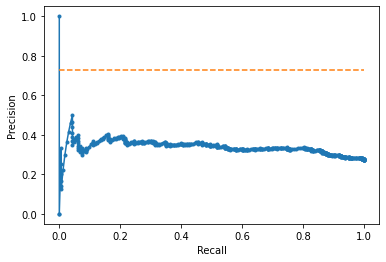

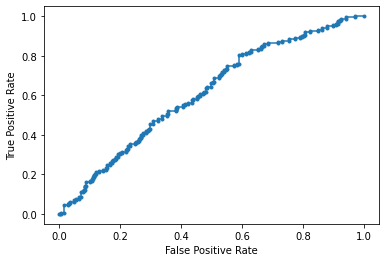

Accuracy: 72.82% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 33.79% AUROC: 61.25%
2023-03-04 19:49:08.752278
Fold 2
Discriminator ZERO 0
FIT
2023-03-04 19:49:10.612631
PREDICT
2023-03-04 19:49:14.223079
True 1:0 159:437 26.68%
Pred 1:0 0:596  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


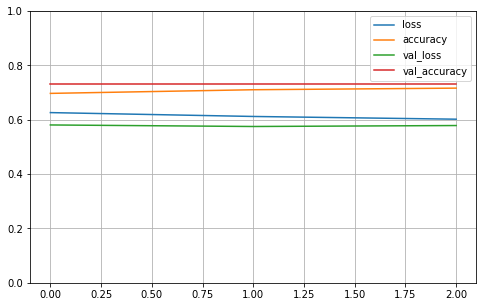

Train set ones/size 335 / 1191
Compute valiation accuracy
Valid sizes (596, 4997) (596,)
Valid set ones/size 159 / 596
Range of scores: 0.1886878 to 0.4296141
Score threshold 0.5
Prediction set ones/size 0 / 596


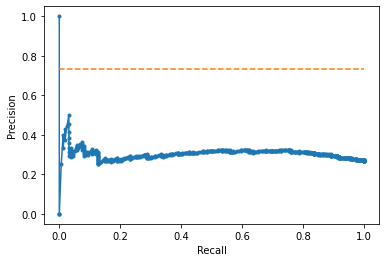

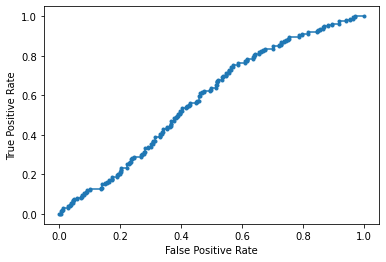

Accuracy: 73.32% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 30.45% AUROC: 58.19%
2023-03-04 19:49:15.476255
Fold 3
Discriminator ZERO 0
FIT
2023-03-04 19:49:17.447689
PREDICT
2023-03-04 19:49:20.874663
True 1:0 173:422 29.08%
Pred 1:0 0:595  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


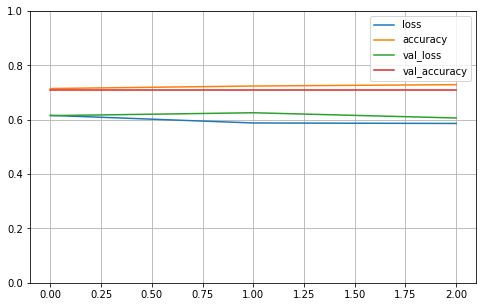

Train set ones/size 321 / 1192
Compute valiation accuracy
Valid sizes (595, 4997) (595,)
Valid set ones/size 173 / 595
Range of scores: 0.16206966 to 0.45838553
Score threshold 0.5
Prediction set ones/size 0 / 595


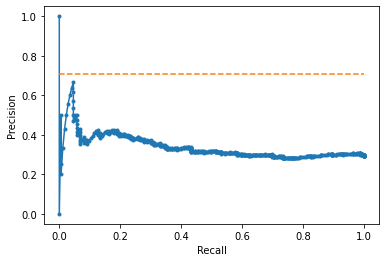

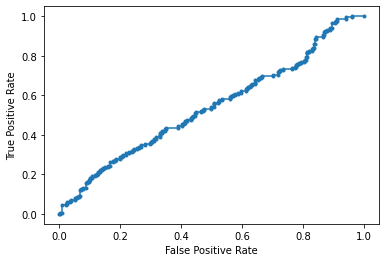

Accuracy: 70.92% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 33.76% AUROC: 54.14%
2023-03-04 19:49:21.806484

Completed cross validation 3 folds 3 epochs
Finished cell Line 11 SK.N.SH

2023-03-04 19:49:23.110390
Start cell Line 12 GM12878
Number of RCI values loaded 1931
Num RCI: 1931
Load sequence...
Cross validation...
2023-03-04 19:49:25.799035
splitting
Fold 1
Discriminator ZERO 0
FIT
2023-03-04 19:49:26.460905
PREDICT
2023-03-04 19:49:30.895306
True 1:0 162:453 26.34%
Pred 1:0 0:615  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


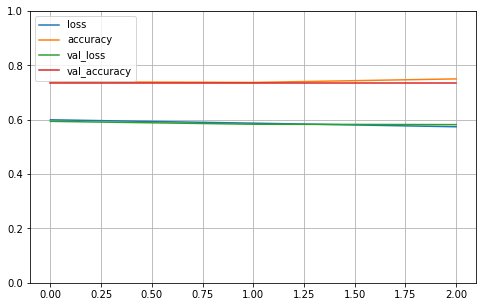

Train set ones/size 306 / 1229
Compute valiation accuracy
Valid sizes (615, 4997) (615,)
Valid set ones/size 162 / 615
Range of scores: 0.22236581 to 0.41615713
Score threshold 0.5
Prediction set ones/size 0 / 615


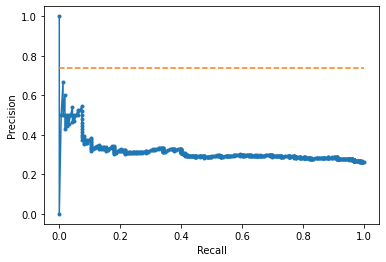

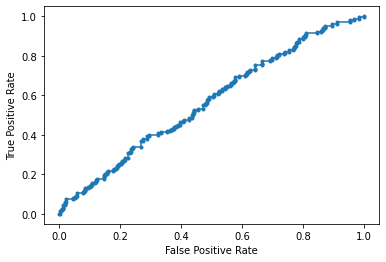

Accuracy: 73.66% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 31.58% AUROC: 56.71%
2023-03-04 19:49:31.795785
Fold 2
Discriminator ZERO 0
FIT
2023-03-04 19:49:33.662952
PREDICT
2023-03-04 19:49:37.255908
True 1:0 158:457 25.69%
Pred 1:0 0:615  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


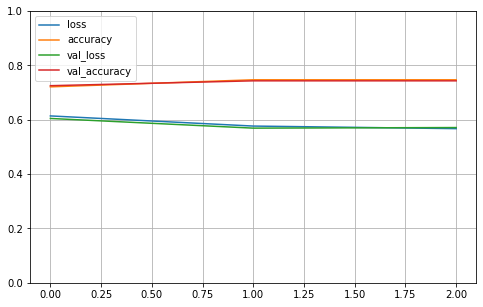

Train set ones/size 310 / 1229
Compute valiation accuracy
Valid sizes (615, 4997) (615,)
Valid set ones/size 158 / 615
Range of scores: 0.22452822 to 0.4259013
Score threshold 0.5
Prediction set ones/size 0 / 615


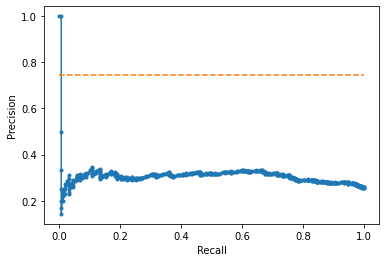

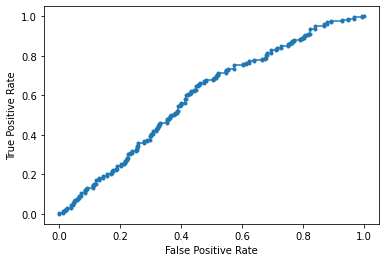

Accuracy: 74.31% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 30.85% AUROC: 59.75%
2023-03-04 19:49:38.187204
Fold 3
Discriminator ZERO 0
FIT
2023-03-04 19:49:40.228308
PREDICT
2023-03-04 19:49:46.871246
True 1:0 148:466 24.10%
Pred 1:0 0:614  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


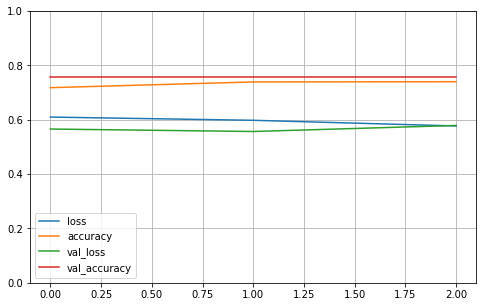

Train set ones/size 320 / 1230
Compute valiation accuracy
Valid sizes (614, 4997) (614,)
Valid set ones/size 148 / 614
Range of scores: 0.26600236 to 0.4310804
Score threshold 0.5
Prediction set ones/size 0 / 614


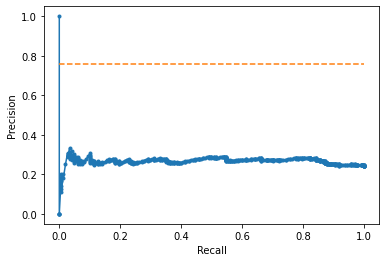

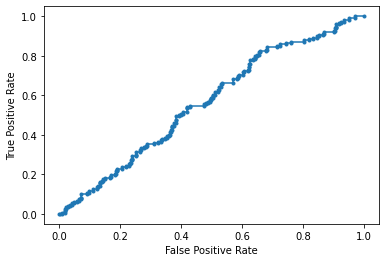

Accuracy: 75.90% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 26.76% AUROC: 56.57%
2023-03-04 19:49:47.785868

Completed cross validation 3 folds 3 epochs
Finished cell Line 12 GM12878

2023-03-04 19:49:49.095542
Start cell Line 13 K562
Number of RCI values loaded 1090
Num RCI: 1090
Load sequence...
Cross validation...
2023-03-04 19:49:50.611874
splitting
Fold 1
Discriminator ZERO 0
FIT
2023-03-04 19:49:51.008751
PREDICT
2023-03-04 19:49:54.565456
True 1:0 101:247 29.02%
Pred 1:0 0:348  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


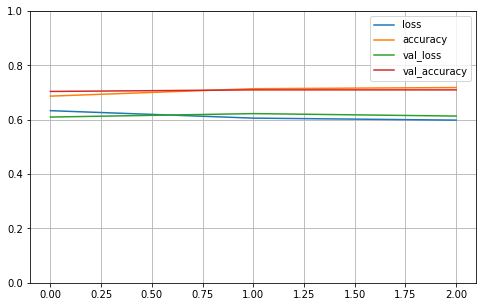

Train set ones/size 196 / 696
Compute valiation accuracy
Valid sizes (348, 4997) (348,)
Valid set ones/size 101 / 348
Range of scores: 0.22163872 to 0.4452926
Score threshold 0.5
Prediction set ones/size 0 / 348


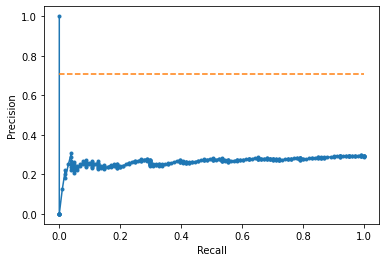

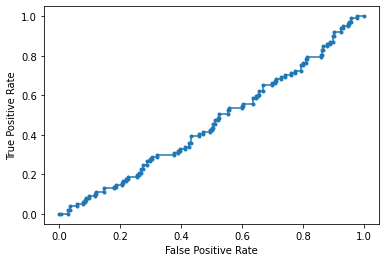

Accuracy: 70.98% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 26.51% AUROC: 46.29%
2023-03-04 19:49:55.746773
Fold 2
Discriminator ZERO 0
FIT
2023-03-04 19:49:57.492171
PREDICT
2023-03-04 19:50:00.260457
True 1:0 93:255 26.72%
Pred 1:0 0:348  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


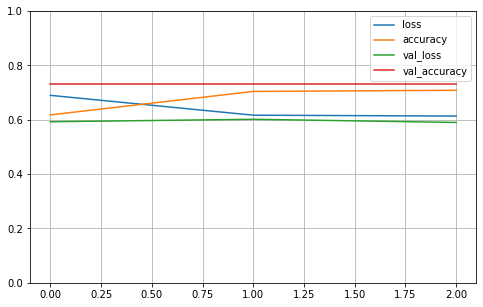

Train set ones/size 204 / 696
Compute valiation accuracy
Valid sizes (348, 4997) (348,)
Valid set ones/size 93 / 348
Range of scores: 0.23824239 to 0.4345779
Score threshold 0.5
Prediction set ones/size 0 / 348


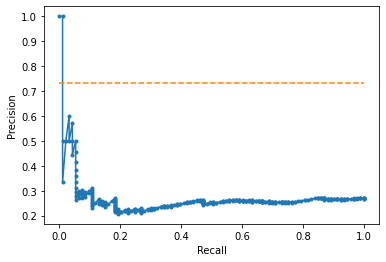

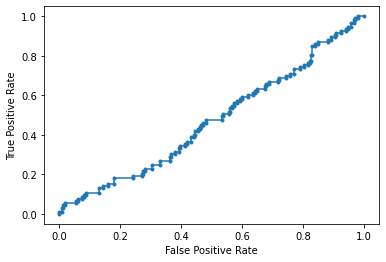

Accuracy: 73.28% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 27.16% AUROC: 47.16%
2023-03-04 19:50:01.090128
Fold 3
Discriminator ZERO 0
FIT
2023-03-04 19:50:02.742928
PREDICT
2023-03-04 19:50:05.446554
True 1:0 103:245 29.60%
Pred 1:0 0:348  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


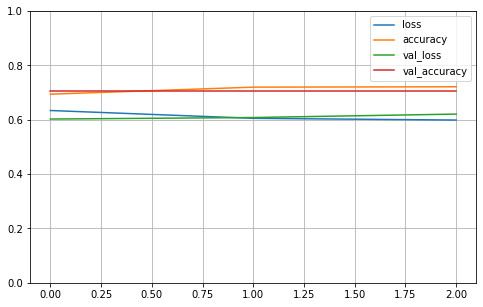

Train set ones/size 194 / 696
Compute valiation accuracy
Valid sizes (348, 4997) (348,)
Valid set ones/size 103 / 348
Range of scores: 0.2525038 to 0.44681108
Score threshold 0.5
Prediction set ones/size 0 / 348


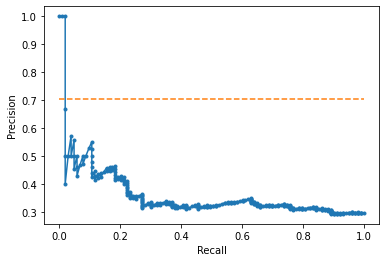

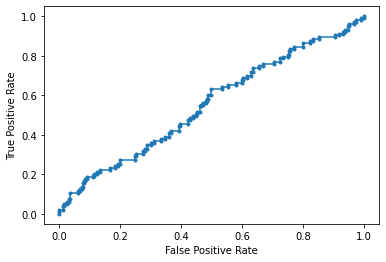

Accuracy: 70.40% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 36.19% AUROC: 55.35%
2023-03-04 19:50:06.272789

Completed cross validation 3 folds 3 epochs
Finished cell Line 13 K562

2023-03-04 19:50:07.599354
Start cell Line 14 IMR.90
Number of RCI values loaded 441
Num RCI: 441
Load sequence...
Cross validation...
2023-03-04 19:50:08.981590
splitting
Fold 1
Discriminator ZERO 0
FIT
2023-03-04 19:50:09.339734
PREDICT
2023-03-04 19:50:12.909659
True 1:0 55:84 39.57%
Pred 1:0 0:139  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


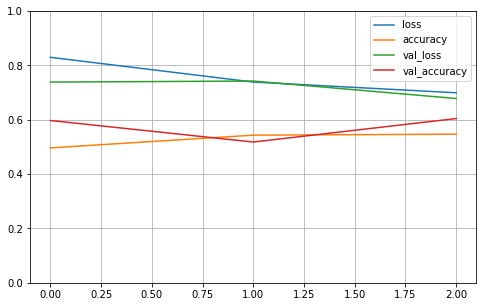

Train set ones/size 125 / 278
Compute valiation accuracy
Valid sizes (139, 4997) (139,)
Valid set ones/size 55 / 139
Range of scores: 0.17470041 to 0.46317497
Score threshold 0.5
Prediction set ones/size 0 / 139


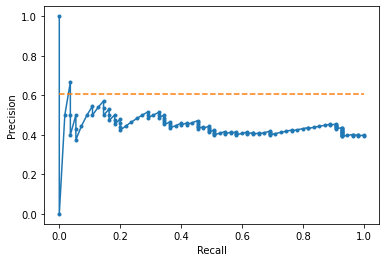

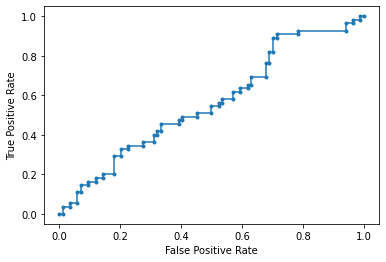

Accuracy: 60.43% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 44.32% AUROC: 56.36%
2023-03-04 19:50:13.715790
Fold 2
Discriminator ZERO 0
FIT
2023-03-04 19:50:15.175639
PREDICT
2023-03-04 19:50:18.707333
True 1:0 58:81 41.73%
Pred 1:0 0:139  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


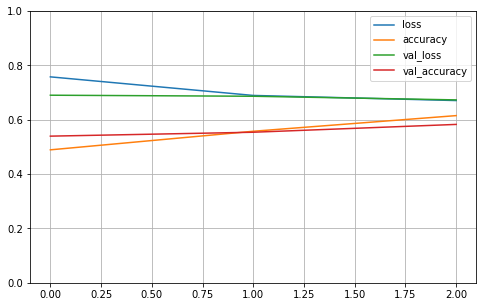

Train set ones/size 122 / 278
Compute valiation accuracy
Valid sizes (139, 4997) (139,)
Valid set ones/size 58 / 139
Range of scores: 0.25796556 to 0.49313018
Score threshold 0.5
Prediction set ones/size 0 / 139


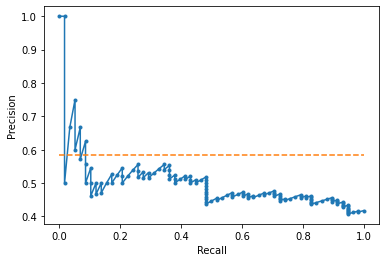

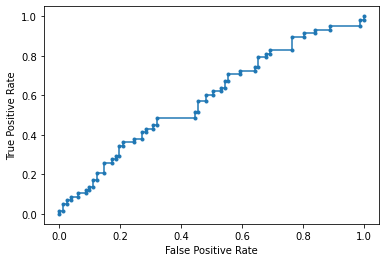

Accuracy: 58.27% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 49.93% AUROC: 58.58%
2023-03-04 19:50:19.627584
Fold 3
Discriminator ZERO 0
FIT
2023-03-04 19:50:21.317025
PREDICT
2023-03-04 19:50:23.964784
True 1:0 67:72 48.20%
Pred 1:0 53:86 38.13%


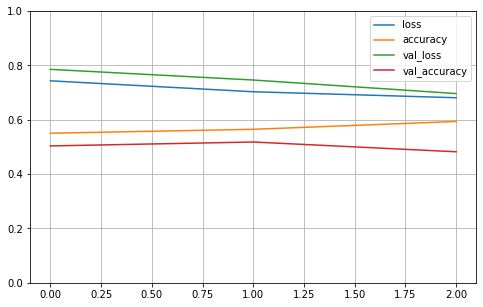

Train set ones/size 113 / 278
Compute valiation accuracy
Valid sizes (139, 4997) (139,)
Valid set ones/size 67 / 139
Range of scores: 0.4110894 to 0.57519776
Score threshold 0.5
Prediction set ones/size 53 / 139


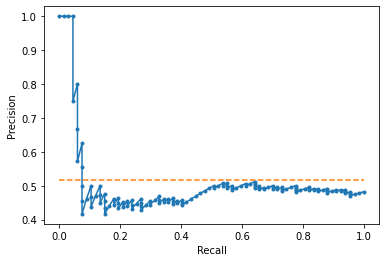

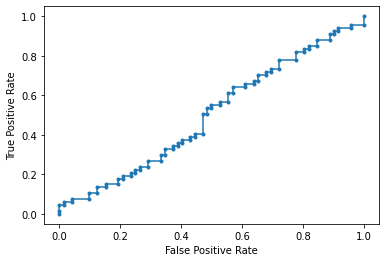

Accuracy: 48.20% Precision: 45.28% Recall: 35.82%
F1: 40.00% AUPRC: 50.52% AUROC: 50.15%
2023-03-04 19:50:24.773722

Completed cross validation 3 folds 3 epochs
Finished cell Line 14 IMR.90

2023-03-04 19:50:26.050857


In [23]:
for CELL_LINE in range(NUM_LINES):
    print(datetime.now())
    print('Start cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE
    gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE)
    print('Num RCI:', len(gene_to_rci.keys()))
    print('Load sequence...')
    filepath = DATA_DIR+SEQUENCE_FILE
    allids,allseq = loader.load_sequence(filepath)
    loader = None  # drop K-mer cache to save RAM

    print("Cross validation...")
    cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
    cvdo.set_sequences(allids,allseq)
    cvdo.set_rci_map(gene_to_rci)
    cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
    cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc = cvdo.do_cross_validation()   
    cvdo = None
    print("Completed cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
    if False:
        print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy,ddof=1)))
        print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision,ddof=1)))
        print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall,ddof=1)))
        print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1,ddof=1)))
        print(" AUPRC mean %.2f%% +/- %.2f" % (np.mean(cv_auprc), np.std(cv_auprc,ddof=1)))
        print(" AUROC mean %.2f%% +/- %.2f" % (np.mean(cv_auroc), np.std(cv_auroc,ddof=1)))
    print('Finished cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    print()
print(datetime.now())